대학 제공 데이터 로드 완료: 1589개 격자
기본 격자 데이터 생성 완료: 1190개 격자

최종 통합 격자 정보 생성 완료!
 최종 통합 격자 수: 1660
 최종 통합 시군구 수: 192
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
1/1 [==============================] - 3s 3s/step
Model prediction complete. Output shape: (1, 82, 67)

결과 테이블 명확화 작업: 5개의 중복 이름 발견 (['Buk-gu', 'Dong-gu', 'Goseong-gun', 'Nam-gu', 'Seo-gu'])

===== Scenario #0 (Boundary Condition: 0.5) =====
Total 201 Sigungu.
           Sido                      Sigungu  Predicted_Average_PM2.5
0         Busan                 Busan_Nam-gu                 7.400000
1         Busan                  Busanjin-gu                10.200000
2         Busan                   Gangseo-gu                10.200000
3         Busan                 Geumjeong-gu                 9.400000
4         Busan                   Gi

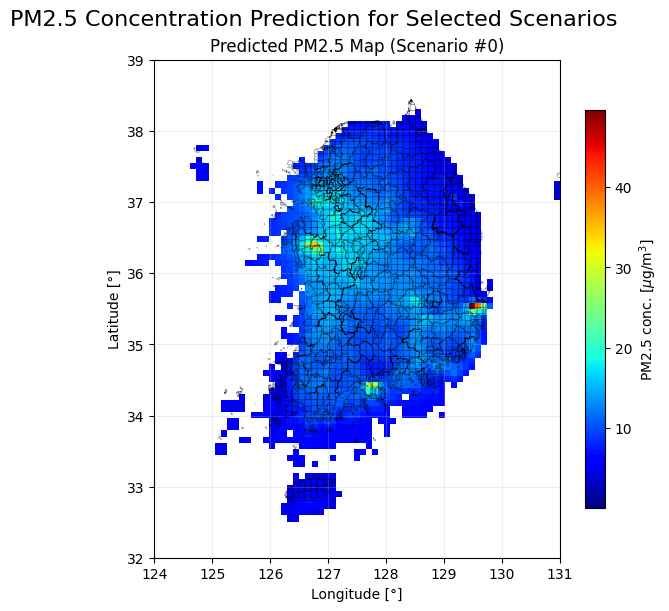

In [2]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

# 모델 라이브러리
# from src.model.cmaqnet_cond_unet import build_model

# 학습 및 처리/분석 관련 라이브러리
import numpy as np
import pandas as pd
import tensorflow as tf

# Geometric 및 시각화 라이브러리
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# 2D Map 결과 도출을 위한 좌표계 설정
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

def get_sigungu_map() -> gpd.GeoDataFrame:
    """시군구 단위의 shapefile을 로드하는 함수"""
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/si_gun_gu/SKOR.shp'
    sigungu_map = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    sigungu_map.crs = 'EPSG:5179'
    return sigungu_map

# =================================================================================
# === 두 데이터 소스를 통합하여 완전한 격자 정보 생성 ===============================
# =================================================================================

def get_base_raster() -> gpd.GeoDataFrame:
    """시뮬레이션 영역에 대한 82x67 베이스 격자망을 포인트 형태로 생성하는 함수"""
    points = [Point(i, j)
              for i in range(-180000, -180000 + 9000 * 67, 9000)
              for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = proj # 좌표계 설정
    grid_data['index'] = grid_data.index
    return grid_data

def create_comprehensive_sigungu_grid() -> pd.DataFrame:
    """
    GRID CSV와 Shapefile을 통합하여 완전한 시군구-격자 할당 정보를 생성합니다.
    - 기본: GRID CSV (시군구 별 면적 비율 정보 포함)
    - 보조: SHP File (영토 영역에 맞추어, 격자 보완)
    """
    # Grid csv파일을 통한 지역(시군구)의 좌표별 Ratio 매핑
    try:
        univ_grid = (
            pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/si_gun_gu_allocation.csv')
            .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False])
            .drop_duplicates(subset=['Row', 'Column'], keep='first')
            .reset_index(drop=True) # reset index
        )
        univ_grid = univ_grid[['Row', 'Column', 'Region_Name', 'SIG_ENG_NM']].copy()
        print(f"대학 제공 데이터 로드 완료: {len(univ_grid)}개 격자")
    except FileNotFoundError:
        print("경고: si_gun_gu_allocation.csv 파일을 찾을 수 없습니다. 정부 데이터만 사용합니다.")
        univ_grid = pd.DataFrame(columns=['Row', 'Column', 'Region_Name', 'SIG_ENG_NM'])

    # 기본 격자와 셰이프 파일을 Spatial Join 하여, 기본 격자 구조에 시군구 정보 추가
    sigungu_map = get_sigungu_map() # 시군구 셰이프 파일 로드
    grid_data = get_base_raster() # 기본 격자 데이터 생성
    sido_code_map = {
        '11': 'Seoul', '26': 'Busan', '27': 'Daegu', '28': 'Incheon',
        '29': 'Gwangju', '30': 'Daejeon', '31': 'Ulsan', '36': 'Sejong',
        '41': 'Gyeonggi', '42': 'Gangwon', '43': 'Chungbuk', '44': 'Chung-Nam',
        '45': 'Jeon-Buk', '46': 'Jeon-Nam', '47': 'Gyeong-Buk', '48': 'Gyeong-Nam',
        '50': 'Jeju'
    }
    joined_gdf = gpd.sjoin(grid_data, sigungu_map.to_crs(grid_data.crs), how='left', predicate='within')
    valid_grids = joined_gdf.dropna(subset=['SIG_CD']).copy()
    valid_grids['Row'] = (valid_grids['index'] % 82) + 1
    valid_grids['Column'] = (valid_grids['index'] // 82) + 1
    valid_grids['Region_Name'] = valid_grids['SIG_CD'].str[:2].map(sido_code_map)
    gov_grid = valid_grids[['Row', 'Column', 'Region_Name', 'SIG_ENG_NM']]
    print(f"기본 격자 데이터 생성 완료: {len(gov_grid)}개 격자")

    # Grid Data와 셰이프가 반영된 기본 격자를 통합
    combined_grid = (
        pd.concat([univ_grid, gov_grid])
        .drop_duplicates(subset=['Row', 'Column'], keep='first')
        .reset_index(drop=True)
    )

    print("\n최종 통합 격자 정보 생성 완료!")
    print(f" 최종 통합 격자 수: {len(combined_grid)}")
    print(f" 최종 통합 시군구 수: {combined_grid['SIG_ENG_NM'].nunique()}")

    return combined_grid

# =================================================================================

# 시군구 지도 데이터 로드 및 좌표계 변환
sigungu_map = get_sigungu_map()
sigungu_map_proj = sigungu_map.to_crs(proj)

# Grid Data와 Shapefile을 통합하여 완전한 시군구-격자 할당 정보 생성
grid_alloc = create_comprehensive_sigungu_grid()

# 인덱스시퀀스 조정 (1-based to 0-based)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

# 대한민국 영토 마스크 생성
row_indices, col_indices = grid_alloc['Row'].values, grid_alloc['Column'].values
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# ------- 시군구 평균 농도 결과 출력 함수 -------

def process_and_display_sigungu_results(pred_maps, boundary_conds, grid_alloc_df, original_indices, idx=1):
    """결과를 처리하고, 중복 이름에 시/도 정보를 추가하여 명확하게 시각화하는 함수"""
    # pred_maps의 첫 번째 차원 크기를 시나리오 수로 설정
    num_scenarios = pred_maps.shape[0]

    # 중복되는 시군구 이름 목록을 미리 찾아둠
    sigungu_counts = grid_alloc_df.groupby('SIG_ENG_NM')['Region_Name'].nunique()
    ambiguous_names = sigungu_counts[sigungu_counts > 1].index.tolist()
    print(f"\n결과 테이블 명확화 작업: {len(ambiguous_names)}개의 중복 이름 발견 ({ambiguous_names})")

    for i in range(num_scenarios):
        sido_col = 'Region_Name'
        sigungu_col = 'SIG_ENG_NM'
        
        sigungu_means_list = []
        # groupby는 그대로 유지하여 지역별로 정확히 계산
        for (sido_name, sgg_name), pixels in grid_alloc_df.groupby([sido_col, sigungu_col]):
            rows, cols = pixels['Row'].values, pixels['Column'].values
            # i번째 시나리오의 예측 결과에서 평균 농도 계산
            mean_conc = np.mean(pred_maps[i, rows, cols])
            sigungu_means_list.append({
                'Sido': sido_name, 
                'Sigungu': sgg_name, 
                'Predicted_Average_PM2.5': mean_conc
            })
        
        df = pd.DataFrame(sigungu_means_list)

        # 중복 이름에 해당하는 행의 'Sigungu' 컬럼 값을 "Sido_Sigungu" 형식으로 변경
        for name in ambiguous_names:
            mask_df = df['Sigungu'] == name
            df.loc[mask_df, 'Sigungu'] = df.loc[mask_df, 'Sido'] + '_' + df.loc[mask_df, 'Sigungu']
        
        df['Predicted_Average_PM2.5'] = df['Predicted_Average_PM2.5'].round(idx)
        df = df.sort_values(by=['Sido', 'Sigungu']).reset_index(drop=True)

        print(f"\n===== Scenario #{original_indices[i]} (Boundary Condition: {boundary_conds[i]}) =====")
        print(f"Total {len(df)} Sigungu.")
        
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(df)
            
        seoul_pixels = grid_alloc_df[grid_alloc_df[sido_col] == 'Seoul']
        if not seoul_pixels.empty:
            rows, cols = seoul_pixels['Row'].values, seoul_pixels['Column'].values
            seoul_avg_conc = np.mean(pred_maps[i, rows, cols])
            print(f"\n* Average PM2.5 for Seoul City (pixel-based): {seoul_avg_conc:.3f} (μg/m³)")

    # 예측 결과 맵 시각화
    cmap_with_white = plt.get_cmap('jet').copy()
    cmap_with_white.set_bad('white')
    local_max = pred_maps.max()
    threshold = 0.01

    fig, axes = plt.subplots(1, num_scenarios, figsize=(7 * num_scenarios, 6), constrained_layout=True)
    if num_scenarios == 1:
        axes = [axes]

    x_min, x_max = -180000 + offset_x, 414000 + offset_x
    y_min, y_max = -585000 + offset_y, 144000 + offset_y
    x_ticks, x_labels = np.linspace(x_min, x_max, 8), [str(i) for i in range(124, 132)]
    y_ticks, y_labels = np.linspace(y_min, y_max, 8), [str(i) for i in range(32, 40)]
    
    for i in range(num_scenarios):
        ax = axes[i]
        # i번째 시나리오의 예측 맵 선택
        data_pred = pred_maps[i]
        masked_pred = np.ma.masked_where(data_pred[::-1] <= threshold, data_pred[::-1])
        
        im = ax.imshow(
            masked_pred, cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold, vmax=local_max
        )
        sigungu_map_proj.boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.3)
        ax.set_title(f"Predicted PM2.5 Map (Scenario #{original_indices[i]})")
        ax.set_xlabel('Longitude [°]')
        ax.set_ylabel('Latitude [°]')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
        ax.grid(alpha=0.25, color='silver')

    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.05, pad=0.02, shrink=0.8)
    cbar.set_label('PM2.5 conc. [$\\mu \\mathrm{g}/\\mathrm{m}^3$]')
    plt.suptitle("PM2.5 Concentration Prediction for Selected Scenarios", fontsize=16)
    plt.show()

# ================================================================================

# ------ Prediction -------
# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
strategy = tf.distribute.MirroredStrategy()

# 0. 학습된 모델 로드
with strategy.scope():
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/pm25_prediction/yearly_prediction_model_PM25')

# 1. 입력 데이터셋 로드 (시도 단위 배출량)
try:
    emis_ctrl_2019_05 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
except FileNotFoundError:
    print("오류: '/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019.csv' 파일을 찾을 수 없습니다.")
    sys.exit()

# 2. 전체 238개 시나리오 생성
emis_ctrl_2019_05['Boundary'] = 0.5
emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0
ctrl_data = pd.concat([emis_ctrl_2019_05, emis_ctrl_2019_10], axis=0).reset_index(drop=True)

# 3. 분석할 3개 시나리오 선택
scenario_indices_to_process = [0]
selected_ctrl_data = ctrl_data.iloc[scenario_indices_to_process]
pred_emis_data = selected_ctrl_data.iloc[:, :17*5].values
pred_boundary_data = selected_ctrl_data.iloc[:, 17*5].values

# 4. 모델 추론 진행 및 출력 형태를 (시나리오 수, 높이, 너비)로 일관성 있게 조정
y_preds = model.predict([pred_emis_data,  pred_boundary_data])

# 모델 출력이 (..., 1) 형태일 경우 마지막 차원 제거 (e.g., (1, 82, 67, 1) -> (1, 82, 67))
if y_preds.ndim == 4 and y_preds.shape[-1] == 1:
    y_preds = np.squeeze(y_preds, axis=-1)

# 단일 시나리오 예측 시 (82, 67) 형태로 나오는 것을 (1, 82, 67)로 차원 유지
if y_preds.ndim == 2:
    y_preds = y_preds[np.newaxis, :, :]
    
print("Model prediction complete. Output shape:", y_preds.shape)

# 5. 예측 결과에 마스크 적용 (시나리오 수 기반)
num_scenarios_predicted = y_preds.shape[0]
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=num_scenarios_predicted, axis=0)
pred_conc_map = np.where(mask_expanded == 1, y_preds, 0)

process_and_display_sigungu_results(
    pred_maps=pred_conc_map,
    boundary_conds=pred_boundary_data,
    grid_alloc_df=grid_alloc,
    original_indices=scenario_indices_to_process,
    idx=1
)